In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from tyssue import Sheet
from tyssue import PlanarGeometry
from tyssue.generation import generate_ring
from tyssue import config
from tyssue.draw import sheet_view





# Geometry classes

A `Geometry` class is a stateless class holding functions to compute geometrical aspects of an epithelium,
such as the edge lengths or the cells volume. As they are classes, inheritance can be used to define more and more specialized geometries.

For the user, a geometry class is expected to have an `update_all` method that takes an `Epithelium` instance as sole argument.

Calling this method will compute the relevant geometry on the epithelium.


## 2D Geometries 



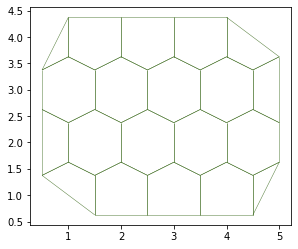

In [2]:
sheet_2d = Sheet.planar_sheet_2d('planar', nx=6, ny=6, 
                                 distx=1, disty=1)
sheet_2d.sanitize(trim_borders=True, order_edges=True)
fig, ax = sheet_view(sheet_2d)

### Displacing vertices

Most of the geometry is purely defined by the vertex positions. It is possible to change those by modifying directly the vertex dataframe


For exemple, we can center the vertices around 0 like so:

In [3]:
com = sheet_2d.vert_df[sheet_2d.coords].mean(axis=0)
print("Sheet center of mass :")
print(com)

# Translate vertices by - 

sheet_2d.vert_df[sheet_2d.coords] -= com

print("New center of mass :")
print(sheet_2d.vert_df[sheet_2d.coords].mean(axis=0))

Sheet center of mass :
x    2.75
y    2.50
dtype: float64
New center of mass :
x    0.0
y    0.0
dtype: float64


The view does not change though:

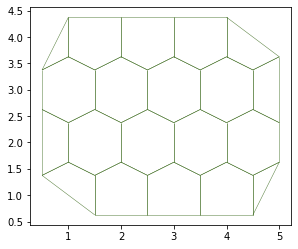

In [4]:
fig, ax = sheet_view(sheet_2d)

In order to propagate the change in vertex positions, we need to **update the geometry**:

In [5]:
PlanarGeometry.update_all(sheet_2d)

Now the sheet is centered:

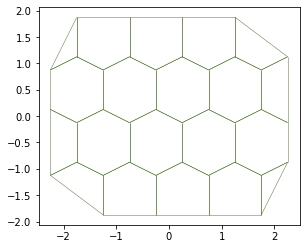

In [6]:
fig, ax = sheet_view(sheet_2d)

### Closed 2D geometry

We can also use the `generate_ring` function to create a 2D ring of 4-sided cells.

In [7]:
ring = generate_ring(Nf=24, R_in=12, R_out=14)
PlanarGeometry.update_all(ring)


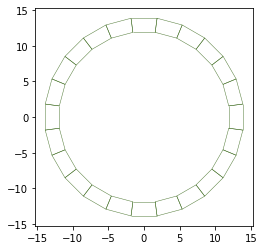

In [8]:
fig, ax = sheet_view(ring)


There is an `AnnularGeometry` class that does all `PlanarGeometry` does plus computing the "lumen" volume, here the area inside the ring.

In [9]:
from tyssue.geometry.planar_geometry import AnnularGeometry

In [10]:
AnnularGeometry.update_all(ring)
print(ring.settings["lumen_volume"])

894.4786198743117


## Sheet geometry in 2.5D


The `SheetGeometry` class computes the geometry of a 2D surface mesh embeded in 3D. The positions of the vertices and edges are thus defined in 3D.

In [11]:
from tyssue import SheetGeometry

sheet_3d = Sheet.planar_sheet_3d(
    'sheet', nx=6, ny=6, distx=1, disty=1
)
sheet_3d.sanitize(trim_borders=True)
SheetGeometry.update_all(sheet_3d)



In [12]:
sheet_3d.vert_df.head()

,y,is_active,x,z,rho,height,basal_shift
vert,,,,,,,
0,2.625,1,0.5,0,0,-4.0,4.0
1,3.375,1,1.5,0,0,-4.0,4.0
2,2.625,1,2.5,0,0,-4.0,4.0
3,3.375,1,0.5,0,0,-4.0,4.0
4,3.625,1,1.0,0,0,-4.0,4.0


In [13]:
sheet_3d.face_df.head()

,y,is_alive,perimeter,area,x,num_sides,id,z,height,rho,vol
face,,,,,,,,,,,
0,1.250000,1,3.118034,0.5000,1.125000,4,0,0,-4.0,0,-2.00
1,1.125000,1,3.618034,0.8750,2.000000,5,0,0,-4.0,0,-3.50
2,1.125000,1,3.618034,0.8750,3.000000,5,0,0,-4.0,0,-3.50
3,1.125000,1,3.618034,0.8750,4.000000,5,0,0,-4.0,0,-3.50
4,1.208333,1,2.427051,0.1875,4.666667,3,0,0,-4.0,0,-0.75


We can use the `height` columns to compute a pseudo-volume for each face, computed as the face area times it's height.

### Relative coordinates in `edge_df`

The edge dataframe stores a copy of the face and source and target vertices positions, and other relative values.

![](illus/double_edges.svg)

In [14]:
sheet_3d.edge_df.head()

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,is_active,ux,uy,uz,is_valid,rx,ry,rz,sub_area,sub_vol
edge,,,,,,,,,,,,,,,,,,,,,
0,0,0.3750,0.750000,10,3,0.0,-0.75,0.5,3.375,0.5,...,1,0.0,-0.75,0.0,True,-0.5,0.375,0,0.18750,-0.750
1,6,0.3750,0.750000,7,5,0.0,0.75,3.0,1.625,3.0,...,1,0.0,0.75,0.0,True,0.5,-0.375,0,0.18750,-0.750
2,5,0.3750,0.750000,8,6,0.0,-0.75,3.0,2.375,3.0,...,1,0.0,-0.75,0.0,True,-0.5,0.375,0,0.18750,-0.750
3,10,0.3125,0.559017,8,5,0.5,-0.25,3.0,1.625,3.5,...,1,0.5,-0.25,0.0,True,-0.5,-0.375,0,0.15625,-0.625
4,5,0.2500,0.559017,2,10,-0.5,0.25,3.5,1.375,3.0,...,1,-0.5,0.25,0.0,True,0.5,0.250,0,0.12500,-0.500


### Closed sheet in 2.5D


For closed surfaces, a `ClosedSheetGeometry` is available. Calling `update_all` computes the enclosed volume of the sheet, and stores it the `settings` attribute as `"lumen_vol"`





In [15]:
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry
from tyssue.generation import ellipsoid_sheet

ellipso = ellipsoid_sheet(a=12, b=12, c=21, n_zs=12)
ClosedSheetGeometry.update_all(ellipso)

In [16]:
lumen_vol = ellipso.settings['lumen_vol']

print(f"Lumen volume: {lumen_vol: .0f}")

Lumen volume:  11440


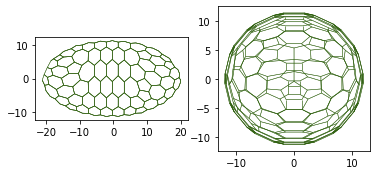

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2)

fig, ax0 = sheet_view(
    ellipso, 
    coords=["z", "y"],
    ax=ax0
)
fig, ax1 = sheet_view(
    ellipso, 
    coords=["x", "y"],
    ax=ax1
)

`sheet_view` can be called in 3D mode with ipyvolume:

In [19]:
import ipyvolume as ipv
ipv.clear()
fig, mesh = sheet_view(ellipso, mode="3D")
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

![3D view of the ellipsoid](illus/small_ellipsoid3D.png)

## Monolayer 

To represent monolayers, we add a `cell` element and dataframe to the datasets.

One easy way to create a monolayer is to extrude it from a sheet, that means duplicating the 2D mesh to represent the basal surface and linking both meshes together to form lateral faces.

In [20]:
from tyssue import Monolayer, MonolayerGeometry, ClosedMonolayerGeometry
from tyssue.generation import extrude

extruded = extrude(sheet_3d.datasets, method='translation')
specs = config.geometry.bulk_spec()
monolayer = Monolayer('mono', extruded, specs)
MonolayerGeometry.update_all(monolayer)
MonolayerGeometry.center(monolayer)


In [21]:
monolayer.cell_df.head()

,x,y,z,is_alive,area,vol,num_faces,id,num_ridges
cell,,,,,,,,,
0,1.125000,1.250000,-0.5,1,4.118034,0.5000,6,0,24
1,2.000000,1.125000,-0.5,1,5.368034,0.8750,7,0,30
2,3.000000,1.125000,-0.5,1,5.368034,0.8750,7,0,30
3,4.000000,1.125000,-0.5,1,5.368034,0.8750,7,0,30
4,4.666667,1.208333,-0.5,1,2.802051,0.1875,5,0,18


In `cell_df`, the `num_faces` is self-explanatory, and the `num_ridges` the number of half_edges on the face.

Similarly to edges, in 3D each face is a "half face", i.e. the interface between two cells consists of two faces, one per cell.

In [22]:
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D")
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

![](illus/simple_monolayer.png)

Faces and edges in a monolayer belong to a segment: apical, basal or lateral.

In [23]:
monolayer.face_df["segment"].unique()

array(['apical', 'basal', 'lateral'], dtype=object)

We can filter the data based on these segments:

In [24]:
apical_faces = monolayer.face_df[
    monolayer.face_df["segment"] == "apical"
]

It is possible to extract the basal or apical sheets from a monolayer with `monolayer.get_sub_sheet`:

In [25]:
basal = monolayer.get_sub_sheet("basal")

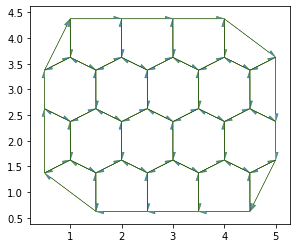

In [26]:
fig, ax = sheet_view(basal, coords=['x', 'y'], edge={"head_width": 0.1})

(Notice the basal sheet is oriented downward).

### Closed Monolayer

Similarly to sheet, monolayers can be closed with a defined lumen.

In [27]:
datasets = extrude(ellipso.datasets, method='homotecy', scale=0.9)

mono_ellipso = Monolayer('mono_ell', datasets)
mono_ellipso.vert_df['z'] += 5

ClosedMonolayerGeometry.update_all(mono_ellipso)

ipv.clear()

fig, mesh = sheet_view(mono_ellipso, mode="3D")
fig


Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [28]:
mono_ellipso.settings

{'lumen_vol': 8344.553887776496}

## Bulk tissue 


Eventually, we can define arbitrary assemblies of cells. 

A way to generate such a tissue is through 3D Voronoi tessalation:

In [29]:
from tyssue import Epithelium, BulkGeometry
from tyssue.generation import from_3d_voronoi, hexa_grid3d
from tyssue.draw import highlight_cells
from scipy.spatial import Voronoi

cells = hexa_grid3d(4, 4, 6)
datasets = from_3d_voronoi(Voronoi(cells))
bulk = Epithelium('bulk', datasets)
bulk.reset_topo()
bulk.reset_index(order=True)
bulk.sanitize()

BulkGeometry.update_all(bulk)

# We'll see next how to configure visualisation

bulk.face_df['visible'] = False

highlight_cells(bulk, [12, 4])
ipv.clear()
fig2, mesh = sheet_view(bulk, mode="3D",
                        face={"visible":True})
fig2

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

### Advanced example: better initial cells

Due to artifacts in the Voronoï tessalation at the boundaries of the above epithelium, the cells are ugly, with vertices protruding away from the tissue.

Here we show how to bring the vertices too far from the cell at a closer distance to the cells.

This will be the occasion to apply "upcasting" and "downcasting".



Our algorithm is simple: for each vertex belonging to only one cell[^1], bring the vertex at a distance equal to the median cell-vertex distance towards the cell. Here is a 2D illustration:


![](illus/vertexcorrection.svg)

[^1]: This is not strictly necessary, we could do this for all the vertices, but it makes for an interesting example of filtering.

##### Step 1. get the vertices that belong to a single cell


`edge_df` stores the topology of the tissue. We can use [Apply / Groupby](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) strategies to get vertices with only one cell:

In [30]:
bulk.vert_df['num_cells'] = bulk.edge_df.groupby("srce").apply(lambda df: df['cell'].unique().size)
bulk.vert_df['num_cells'].head()

vert
0    3
1    1
2    1
3    2
4    1
Name: num_cells, dtype: int64

#### Step 2. Create a binary mask over  vertices with only one neighbor cell

In [31]:
lonely_vs = bulk.vert_df['num_cells'] < 2

#### Step 3. For each source vertex, compute the vector from cell center to the vertex, its length, and the median distance





In [32]:
rel_pos = bulk.edge_df[['sx', 'sy', 'sz']].to_numpy() - bulk.edge_df[['cx', 'cy', 'cz']].to_numpy()
    
rel_dist = np.linalg.norm(rel_pos, axis=1)
med_dist = np.median(rel_dist)

The displacement we need to apply is parallel to the cell-to-vertex vector, and can be expressed as:

In [33]:
displacement = rel_pos * (med_dist / rel_dist - 1)[:, np.newaxis]

We use [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis) to multiply 2D arrays of shape (Ne, 3) with 1D arrays of shape (Ne,). 

This is still defined for each edge source.

We can come back to vertices by taking the mean over all outgoing edges:

In [34]:
# create a df so we can groupby
displacement = pd.DataFrame(displacement, index=bulk.edge_df.index)
displacement['srce'] = bulk.edge_df['srce']
vert_displacement = displacement.groupby("srce").mean()


Now we filter this with `lonely_vs`:

In [35]:
vert_displacement[~lonely_vs] = 0

Apply the displacement and update the geometry:

In [36]:
bulk.vert_df[['x', 'y', 'z']] += vert_displacement.to_numpy()

BulkGeometry.update_all(bulk)
ipv.clear()
fig2, mesh = sheet_view(bulk, mode="3D",
                        face={"visible":True})
fig2

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…